## Oslo city bike data exploration analysis

In Oslo, the capital of Norway, bikes can be rented and returned at (presently) 230 locations in the city. Riding a bike to get around the city is very popular during the summer time. Below I do some exploratory data analysis from the data I got from https://developer.oslobysykkel.no/data and https://yr.no. 

This notebook is for my learning and everyone is free to use the code. Please also give suggestions to improve the code.

The pic below taken from https://visitoslo.com

![title](bike_pic.jpeg)

## Imorting modules

In [181]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(color_codes=True)

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

import json
from pandas.io.json import json_normalize

import datetime
import calendar

import gmaps

import folium

## Loading of data

In [7]:
#Loading of bike data
april18=pd.read_csv('trips-2018.4.1-2018.4.30.csv',parse_dates=['Start time','End time'])
may18=pd.read_csv('trips-2018.5.1-2018.5.31.csv',parse_dates=['Start time','End time'])
june18=pd.read_csv('trips-2018.6.1-2018.6.30.csv',parse_dates=['Start time','End time'])
july18=pd.read_csv('trips-2018.7.1-2018.7.31.csv',parse_dates=['Start time','End time'])

july17=pd.read_csv('trips-2017.7.1-2017.7.31.csv',parse_dates=['Start time','End time'])
july16=pd.read_csv('trips-2016.7.1-2016.7.31.csv',parse_dates=['Start time','End time'])

In [8]:
# Let's look at the columns
july18.head()

,Start station,Start time,End station,End time
0,207,2018-07-01 04:00:15,177,2018-07-01 04:06:37
1,189,2018-07-01 04:00:34,203,2018-07-01 04:05:38
2,470,2018-07-01 04:00:38,247,2018-07-01 04:07:39
3,246,2018-07-01 04:00:46,242,2018-07-01 04:11:59
4,222,2018-07-01 04:00:55,247,2018-07-01 04:08:52


In [26]:
#Combine data for all the available months of 2018
dfcomb=pd.concat([april18,may18,june18,july18])

In [27]:
#Let's add a column for the duration of the rented period. The period in minutes.
dfcomb['duration']=((dfcomb['End time']-dfcomb['Start time']).dt.total_seconds())/60.0

In [28]:
dfcomb.describe()

,Start station,End station,duration
count,1.686706e+06,1.686706e+06,1.686706e+06
mean,2.758795e+02,2.764166e+02,1.585371e+01
std,8.208443e+01,8.199220e+01,1.176022e+02
min,1.570000e+02,1.570000e+02,-3.520000e+01
25%,2.070000e+02,2.080000e+02,5.550000e+00
50%,2.620000e+02,2.620000e+02,9.266667e+00
75%,3.450000e+02,3.450000e+02,1.568333e+01
max,4.860000e+02,4.860000e+02,3.025447e+04


We can see from the above output that there is negative duration for some data entries and the maximum period is nearly 20 days! Let's now clean the data 

In [29]:
cutoffduration=200.0 # value of duration above which the data is ignored
dfcomb=dfcomb.drop(dfcomb[(dfcomb['duration']>cutoffduration)|(dfcomb['duration']<0)].index)

Let's also drop the points when the start and end point are the same and the duration is less than one minute. These are typically the instances when a user decided not to take the bike.

In [129]:
dfcomb=dfcomb.drop(dfcomb[(dfcomb['duration']<1)&(dfcomb['Start station']==dfcomb['End station'])].index)

In [130]:
dfcomb.describe()

,duration,Hour
count,1.490987e+06,1.490987e+06
mean,1.333106e+01,1.594291e+01
std,1.335296e+01,4.501422e+00
min,2.500000e-01,2.133333e+00
25%,5.866667e+00,1.290000e+01
50%,9.516667e+00,1.653333e+01
75%,1.591667e+01,1.931667e+01
max,1.999833e+02,2.598333e+01


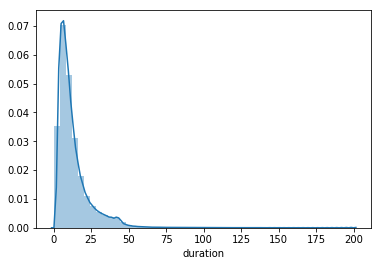

In [32]:
# Let's plot to see if the cutoff of 200 is justified
sns.distplot(dfcomb['duration'])

A Chi-squared distribution

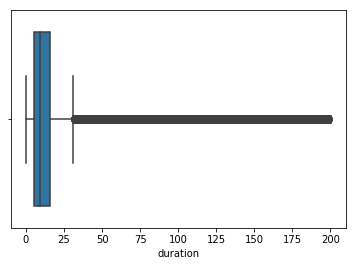

In [33]:
sns.boxplot(dfcomb['duration'][dfcomb['duration']<1000.0])

In [38]:
dfcomb['Date']= dfcomb['Start time'].dt.date

In [49]:
dfcomb['Month']= (dfcomb['Start time'].dt.month).apply(lambda x: calendar.month_abbr[x])
dfcomb['Month'].head()

0    Apr
1    Apr
2    Apr
3    Apr
4    Apr
Name: Month, dtype: object

In [117]:
dfcomb['Hour']= 2+ dfcomb['Start time'].dt.hour +dfcomb['Start time'].dt.minute/60.0
# The 2 is added to convert to CEST

#dfcomb['Minute']= dfcomb['Start time'].dt.minute

In [115]:
dfcomb['Day']= dfcomb['Start time'].dt.weekday_name

In [122]:
dfcomb=dfcomb.drop(['Start time','End time','Minute'],axis=1);

In [123]:
dfcomb.head()

,Start station,End station,duration,Date,Month,Hour,Day
0,222,222,8.916667,2018-04-01,Apr,15.566667,Sunday
1,204,204,0.966667,2018-04-03,Apr,16.466667,Tuesday
2,204,204,0.700000,2018-04-04,Apr,6.150000,Wednesday
3,274,204,4.533333,2018-04-04,Apr,7.100000,Wednesday
4,247,279,4.150000,2018-04-04,Apr,7.183333,Wednesday


In [124]:
dfcomb.describe()

,duration,Hour
count,1.667985e+06,1.667985e+06
mean,1.292379e+01,1.594511e+01
std,1.330944e+01,4.498574e+00
min,0.000000e+00,2.133333e+00
25%,5.550000e+00,1.291667e+01
50%,9.233333e+00,1.653333e+01
75%,1.558333e+01,1.931667e+01
max,1.999833e+02,2.598333e+01


# The bike traffic during various hours

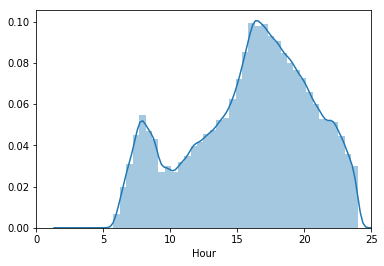

In [93]:
plt.xlim(0, 25)
sns.distplot(dfcomb.Hour,hist_kws={"range": [0,24]})

We see that ~5% users might be renting bikes to get to work/school, hence the increase during the early hours. The trend decreases and then again picks up (at ~10). 

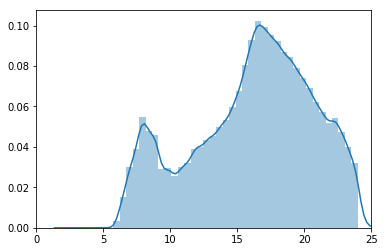

In [96]:
#Return times
plt.xlim(0, 25)
sns.distplot(dfcomb.Hour+dfcomb.duration/60.0,hist_kws={"range": [0,24]})

Looking at the city-bike webpage, I found out that the bikes can be rented from 6 until 24. The above plot shows this nicely.

Let's see the behaviour for some months

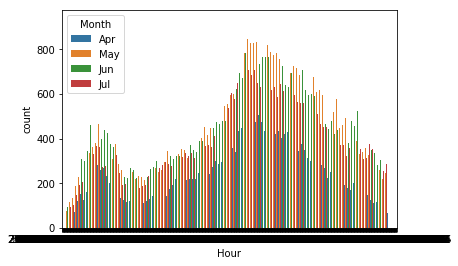

In [100]:
sns.countplot(data=dfcomb,x='Hour',hue='Month')

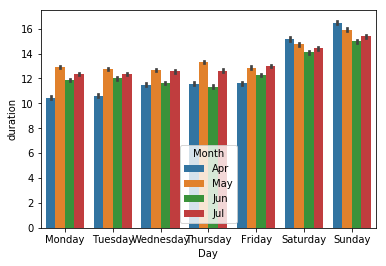

In [126]:
week=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
sns.barplot(x='Day',y='duration',data=dfcomb,order=week,hue="Month")

April being colder has less number of rides. July is a vacation month in Norway, so again less users.

## Some numbers

In [112]:
print('Average ride times (in minutes) for April, May, June and July are',\
      dfcomb.duration[dfcomb.Month=='Apr'].mean(),',',\
      dfcomb.duration[dfcomb.Month=='May'].mean(),',',\
      dfcomb.duration[dfcomb.Month=='Jun'].mean(),' and ',\
      dfcomb.duration[dfcomb.Month=='Jul'].mean())

Average ride times (in minutes) for April, May, June and July are 12.532472669367852 , 13.450303707911988 , 12.45594066290842  and  13.087752932035771


In [111]:
print('Rentals for April, May, June and July are',\
      dfcomb.duration[dfcomb.Month=='Apr'].count(),',',\
      dfcomb.duration[dfcomb.Month=='May'].count(),',',\
      dfcomb.duration[dfcomb.Month=='Jun'].count(),' and ',\
      dfcomb.duration[dfcomb.Month=='Jul'].count())

Rentals for April, May, June and July are 267313 , 494609 , 481756  and  424307


## What are the busiest start and end points?

In [118]:
dfcomb['Start station']=dfcomb['Start station'].apply(str)
dfcomb['End station']=dfcomb['End station'].apply(str)

In [170]:
dfcomb['journey']=dfcomb['Start station'].astype(str) +'->'+dfcomb['End station'].astype(str) 

In [167]:
temp1=pd.DataFrame(dfcomb.groupby('Start station')['Day'].count())
temp2=pd.DataFrame(dfcomb.groupby('Start station')['duration'].mean())
start=pd.merge(temp1,temp2,on='Start station')
start['Start station']=start.index # make index a column
start.columns=['rentals','avg_ride','station']
start=start.sort_values(by='rentals',ascending=False)
start.head()

,rentals,avg_ride,station
Start station,,,
274,34868,14.612345,274
292,28565,16.090957,292
222,25420,13.058857,222
233,23743,11.928719,233
196,21201,11.705594,196


In [168]:
temp1=pd.DataFrame(dfcomb.groupby('End station')['Day'].count())
temp2=pd.DataFrame(dfcomb.groupby('End station')['duration'].mean())
end=pd.merge(temp1,temp2,on='End station')
end['End station']=end.index # make index a column
end.columns=['rentals','avg_ride','station']
end=end.sort_values(by='rentals',ascending=False)
end.head()

,rentals,avg_ride,station
End station,,,
274,36859,14.899911,274
292,30576,16.007074,292
222,28365,12.550261,222
233,23825,11.935715,233
465,22855,15.363719,465


We see that the busiest start and end points are the same: ids=274, 292, 222 and 233.
We will see the geographical location of these points below.

## What is the most popular bike route?

In [171]:
temp1=pd.DataFrame(dfcomb.groupby('journey')['Day'].count())
temp2=pd.DataFrame(dfcomb.groupby('journey')['duration'].mean())
s2e=pd.merge(temp1,temp2,on='journey')
s2e['journey']=s2e.index # make index a column
s2e.columns=['rentals','avg_ride','journey']
s2e=s2e.sort_values(by='rentals',ascending=False)
s2e.head()

,rentals,avg_ride,journey
journey,,,
204->274,3353,7.731007,204->274
274->204,3128,7.407460,274->204
274->247,2742,6.860765,274->247
247->274,2024,7.573732,247->274
274->160,1925,8.160216,274->160


The most popular journeys are between ids 274 and 204.

## Getting the location of the stations
I got the locations of the various ids by a API request to city bike webpage, see https://developer.oslobysykkel.no/api

In [172]:
with open('stations.json') as f:
    data = json.load(f)
stationloc=pd.DataFrame(data)
stationloc=stationloc.stations.apply(pd.Series)
stationloc.head()

,id,in_service,title,subtitle,number_of_locks,center,bounds
0,157,True,Nylandsveien,mellom Norbygata og Urtegata,30,"{'latitude': 59.91562, 'longitude': 10.762248}","[{'latitude': 59.915417, 'longitude': 10.76206..."
1,158,True,Bentsebrugata,rett over busstoppet,24,"{'latitude': 59.939194, 'longitude': 10.759168}","[{'latitude': 59.939, 'longitude': 10.758989},..."
2,159,True,Hans Nielsen Hauges plass,Mellom Åsengata og Nordkappgata,21,"{'latitude': 59.939262, 'longitude': 10.774296}","[{'latitude': 59.939117, 'longitude': 10.77443..."
3,160,True,Sjøsiden vest,nærmest fontenen,50,"{'latitude': 59.910213, 'longitude': 10.751687}","[{'latitude': 59.910183, 'longitude': 10.75139..."
4,161,True,St. Hanshaugen park vest,ved busstoppet Colletts gate,20,"{'latitude': 59.926872, 'longitude': 10.738456}","[{'latitude': 59.92678, 'longitude': 10.738284..."


Let's now find the names of our most popular station ids

In [180]:
stationloc[(stationloc.id==274)| (stationloc.id==204)| (stationloc.id==292)| \
           (stationloc.id==222)| (stationloc.id==233)| (stationloc.id==196)| \
           (stationloc.id==160)| (stationloc.id==465)]

,id,in_service,title,subtitle,number_of_locks,center,bounds
3,160,True,Sjøsiden vest,nærmest fontenen,50,"{'latitude': 59.910213, 'longitude': 10.751687}","[{'latitude': 59.910183, 'longitude': 10.75139..."
35,196,True,Ringnes Park,ved Sannergata,18,"{'latitude': 59.92841, 'longitude': 10.759368}","[{'latitude': 59.928394, 'longitude': 10.75920..."
42,204,True,Paléhaven,langs Strandgata,48,"{'latitude': 59.910286, 'longitude': 10.750012}","[{'latitude': 59.910122, 'longitude': 10.74978..."
59,222,True,Olaf Ryes plass,ved Sofienberggata,35,"{'latitude': 59.922413, 'longitude': 10.758127}","[{'latitude': 59.92237, 'longitude': 10.757882..."
70,233,True,Alexander Kiellands Plass,ved Maridalsveien,25,"{'latitude': 59.92805, 'longitude': 10.751203}","[{'latitude': 59.92801, 'longitude': 10.750954..."
106,274,True,Sukkerbiten,ved gangbroen til Sørenga,36,"{'latitude': 59.90503, 'longitude': 10.753658}","[{'latitude': 59.905354, 'longitude': 10.75349..."
119,292,True,Tjuvholmen,nedenfor bussholdeplassen,30,"{'latitude': 59.909508, 'longitude': 10.722561}","[{'latitude': 59.90933, 'longitude': 10.72235}..."
211,465,True,Rådhusbrygge 4,ved Nesoddbåten,40,"{'latitude': 59.91082, 'longitude': 10.730321}","[{'latitude': 59.910793, 'longitude': 10.73010..."


In [214]:
#Visulaization on map
oslo_coordinates = (59.909508,10.753658)
m = folium.Map(location=oslo_coordinates, zoom_start=15)
folium.Marker([59.905354,10.75349],popup=folium.Popup('274')).add_to(m)
folium.Marker([59.910122,10.74978],popup=folium.Popup('204')).add_to(m)
m.save('plot_data.html')
from IPython.display import HTML
HTML('<iframe src=plot_data.html width=700 height=450></iframe>')

The stations 274 and 204 are marked on the above map. 

Location 204 is near the Oslo central railway station and is the central node in the bus, metro and train networks. 

Location 274 or Sørenga is one of the best places for swimming in Oslo. See the pic below to get an idea of how popular it was during the hot summer of 2018 :)
Image credits: Aftenposten https://www.aftenposten.no/osloby/i/OnJO1A/Gjennomforer-ordenstiltak-etter-Sorenga-kaos

Presently, riding a bike or walking are the best ways of going between the two stations. The most probable reason for the huge bike-traffic between the two points is that people come to downtown Oslo (id 204) by bus/tram/metro/train from their homes and then ride a bike to get to Sørenga.

![title](sorenga.jpeg)